In [1]:
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
#import plotly
#import plotly.graph_objs as go

#import plotly.plotly as py
#import cufflinks as cf


#from sklearn.metrics import r2_score


from rpy2.robjects.packages import importr
import rpy2.robjects as ro
#import warnings
#from collections import Counter

In [2]:

try:
    connection = psycopg2.connect(user="sesyr",
                                  password="SeSyR54",
                                  host="51.254.68.36",
                                  port="5432",
                                  database="donnees_trafic")
    cursor = connection.cursor()

    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")
    
    postgreSQL_select_Query = """
    WITH metadata AS (
          SELECT ist.macrosection,
         ist.code_centrale,
         cnl.code_canal,
         sc.sens,
         cc.id_nature_mesure, cc.libelle
        FROM rdv.info_section_troncon ist
        JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
    JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
    JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
    JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%QT_360 %'::text
    
    ), metadatavt AS (
          SELECT distinct ist.macrosection,
         ist.code_centrale,
         cnl.code_canal,
         sc.sens,
         cc.id_nature_mesure, cc.libelle
        FROM rdv.info_section_troncon ist
        JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
    JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
    JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
    JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%VT_360 %'::text
    )
    
    SELECT 
       
       m.macrosection,
       m.sens,
       m.code_centrale,
       m.code_canal, 
       
        
       ts,
       dq.valeur AS qt,
       dv.valeur AS vt
       
       
      FROM metadata  m
      JOIN metadatavt v
      ON m.macrosection = v.macrosection AND m.sens = v.sens AND m.code_centrale = v.code_centrale AND  m.code_canal=  v.code_canal
      
      CROSS JOIN generate_series('2017-05-01' , '2017-05-07','00:06:00'::interval) AS  ts(ts)
      
      LEFT JOIN myrabel.mesure_2 dq    
      ON dq.id_nature_mesure = m.id_nature_mesure
      AND dq.date_mesure = ts 
      
        LEFT JOIN myrabel.mesure_2 dv    
      ON dv.id_nature_mesure = v.id_nature_mesure
      AND dv.date_mesure = ts
      
      
        --WHERE(  dv.date_mesure IS NULL OR dq.date_mesure IS NULL OR dv.date_mesure = dq.date_mesure )
      
     -- WHERE dq.date_mesure IS NOT  NULL AND dv.date_mesure IS NULL  --OR dq.date_mesure IS NULL
      
      """
    

    cursor.execute(postgreSQL_select_Query)
    print("Selecting rows from mobile table using cursor.fetchall")
    records = cursor.fetchall() 
   
   # print("Print each row and it's columns values")
   #for row in records:
       #   print("Macrosection = ", row[0])
        #  print("sens = ", row[1])
         # print("code centrale   = ", row[2])
          #print(" code canal = ", row[3])
        #  print("date_mesure = ", row[4])
         # print("qt_360 = ", row[5]) 
          #print("Vt_360 = ", row[6],"\n" )
            
            
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
        
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")            

You are connected to -  ('PostgreSQL 10.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-28), 64-bit',) 

Selecting rows from mobile table using cursor.fetchall
PostgreSQL connection is closed


In [3]:
df = pd.DataFrame(records, columns=['Macrosection','sens','code_centrale','code_canal','date','qt_360','vt_360'])

#strip code canal which is a char of 3 character with whitespace

df['code_canal'] = df['code_canal'].str.strip()

# add a column that its default value is np.nan

# df.missing

#sorting dates ?
#df = df.sort_values('date')

# replace zeros also with NAN

df = df.replace(0,np.NaN) # np.NaN ca va marcher , np.nan doesnt work anymore !!

# Descriptive Statistics

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38907 entries, 0 to 38906
Data columns (total 7 columns):
Macrosection     38907 non-null object
sens             38907 non-null object
code_centrale    38907 non-null object
code_canal       38907 non-null object
date             38907 non-null datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=120, name=None)]
qt_360           37372 non-null float64
vt_360           35802 non-null float64
dtypes: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=120, name=None)](1), float64(2), object(4)
memory usage: 2.1+ MB


### Split data spatially for each device which means the  intersection of everycode centrale | and code canal --- 

In [169]:
DataFrameDict=df.groupby(['code_canal','code_centrale'])
    
#print to s
for key, item in DataFrameDict:
    print(DataFrameDict.get_group(key).count(), "\n\n")
    #DataFrameDict.get_group(key).to_csv(r'C:\Users\hp\Desktop\Stage IOT TS\devellopement\grouping_by_codes'+ str(key) +'.csv')   


Macrosection     1441
sens             1441
code_centrale    1441
code_canal       1441
date             1441
qt_360           1441
vt_360           1441
dtype: int64 


Macrosection     1441
sens             1441
code_centrale    1441
code_canal       1441
date             1441
qt_360           1441
vt_360           1441
dtype: int64 


Macrosection     1441
sens             1441
code_centrale    1441
code_canal       1441
date             1441
qt_360           1441
vt_360           1441
dtype: int64 


Macrosection     1441
sens             1441
code_centrale    1441
code_canal       1441
date             1441
qt_360           1440
vt_360           1440
dtype: int64 


Macrosection     1441
sens             1441
code_centrale    1441
code_canal       1441
date             1441
qt_360           1440
vt_360           1440
dtype: int64 


Macrosection     1441
sens             1441
code_centrale    1441
code_canal       1441
date             1441
qt_360           1440
vt_360           1

In [5]:
# sort the dataframe
#df.sort_values(by='code_canal', axis=0, inplace=True)
# set the index to be this and don't drop
#df.set_index(keys=['code_canal'], drop=False,inplace=True)
# get a list of names
#names=df['code_canal'].unique().tolist()
# now we can perform a lookup on a 'view' of the dataframe
#names

In [6]:
#create a data frame dictionary to store your data frames
#DataFrameDict = {elem : pd.DataFrame for elem in names}

#for key in DataFrameDict.keys():
 #   DataFrameDict[key] = df[:][df.code_canal == key]

In [1]:
DataFrameDict.describe()
#dd.to_csv(r'C:\Users\hp\Desktop\Stage IOT TS\devellopement\the whole data grouped.csv')   

#add periodicity /  

NameError: name 'DataFrameDict' is not defined

In [173]:
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline

Missingkey=('2', 'SITE_03')

DataFrameDict.get_group(Missingkey).date = pd.to_datetime(DataFrameDict.get_group(Missingkey).date, format='%d/%b/%Y:%H:%M:%S', utc=False)
DataFrameDict.get_group(Missingkey)= DataFrameDict.get_group(Missingkey).set_index('date')


Y=DataFrameDict.get_group(Missingkey).copy()
reference=Y.dropna()
#reference.isna().sum()
mask = np.random.randint(0,2, size=reference.shape[0]).astype(np.bool)

df_mask=reference[['qt_360' , 'vt_360']]

df_mask[mask]=np.nan

df_mask.isna().sum()
#X[mask] = np.nan

SyntaxError: can't assign to function call (<ipython-input-173-3ce1a8380e9d>, line 7)

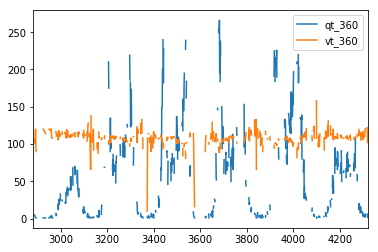

In [172]:
df_mask.plot()

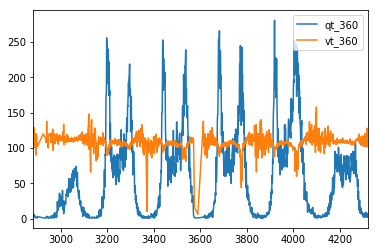

In [166]:
reference[['qt_360' , 'vt_360']].plot()

In [8]:
# Create table for missing data analysis
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [24]:
#for key, item  in DataFrameDict:
         #print("the key is" +str(key)+'\n', find_missing_data(DataFrameDict.get_group(key)),"\n \n")

correlations

In [22]:
Missingkey=('2', 'SITE_03')
DataFrameDict.get_group(Missingkey).head()

,Macrosection,sens,code_centrale,code_canal,date,qt_360,vt_360
2882,I11,SENS_1,SITE_03,2,2017-05-01 00:00:00+02:00,2.0,117.000
2883,I11,SENS_1,SITE_03,2,2017-05-01 00:06:00+02:00,1.0,108.000
2884,I11,SENS_1,SITE_03,2,2017-05-01 00:12:00+02:00,2.0,111.000
2885,I11,SENS_1,SITE_03,2,2017-05-01 00:18:00+02:00,3.0,129.000
2886,I11,SENS_1,SITE_03,2,2017-05-01 00:24:00+02:00,6.0,102.667


In [11]:
#store data in alias dictionary

DataGp = {elem : pd.DataFrame for elem,it in DataFrameDict}

for key in DataGp.keys():
        print(key,end ="  ")
        DataGp[key] = DataFrameDict.get_group(key)
#27 groups        

('0', 'MZE54.3')  ('0', 'MZE54.H')  ('0', 'SITE_03')  ('0', 'SITE_05')  ('0', 'SITE_08')  ('1', 'MZE54.3')  ('1', 'MZE54.4')  ('1', 'MZE54.H')  ('1', 'MZE54.K')  ('1', 'SITE_01')  ('1', 'SITE_03')  ('1', 'SITE_05')  ('1', 'SITE_08')  ('1', 'SITE_09')  ('2', 'MZE54.H')  ('2', 'SITE_03')  ('2', 'SITE_05')  ('2', 'SITE_08')  ('3', 'MZE54.H')  ('3', 'SITE_01')  ('3', 'SITE_03')  ('3', 'SITE_05')  ('3', 'SITE_08')  ('3', 'SITE_09')  ('5', 'SITE_01')  ('5', 'SITE_08')  ('5', 'SITE_09')  

In [12]:
# indexing time for plotting
for key in DataGp.keys():
    DataGp[key].date = pd.to_datetime(DataGp[key].date, format='%d/%b/%Y:%H:%M:%S', utc=False)
    DataGp[key]= DataGp[key].set_index('date')

C:\Users\hp\Anaconda3\envs\Data_imputation\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [13]:
#verify data
DataGp[Missingkey].head()

,Macrosection,sens,code_centrale,code_canal,qt_360,vt_360
date,,,,,,
2017-05-01 00:00:00+02:00,I11,SENS_1,SITE_03,2,2.0,117.000
2017-05-01 00:06:00+02:00,I11,SENS_1,SITE_03,2,1.0,108.000
2017-05-01 00:12:00+02:00,I11,SENS_1,SITE_03,2,2.0,111.000
2017-05-01 00:18:00+02:00,I11,SENS_1,SITE_03,2,3.0,129.000
2017-05-01 00:24:00+02:00,I11,SENS_1,SITE_03,2,6.0,102.667


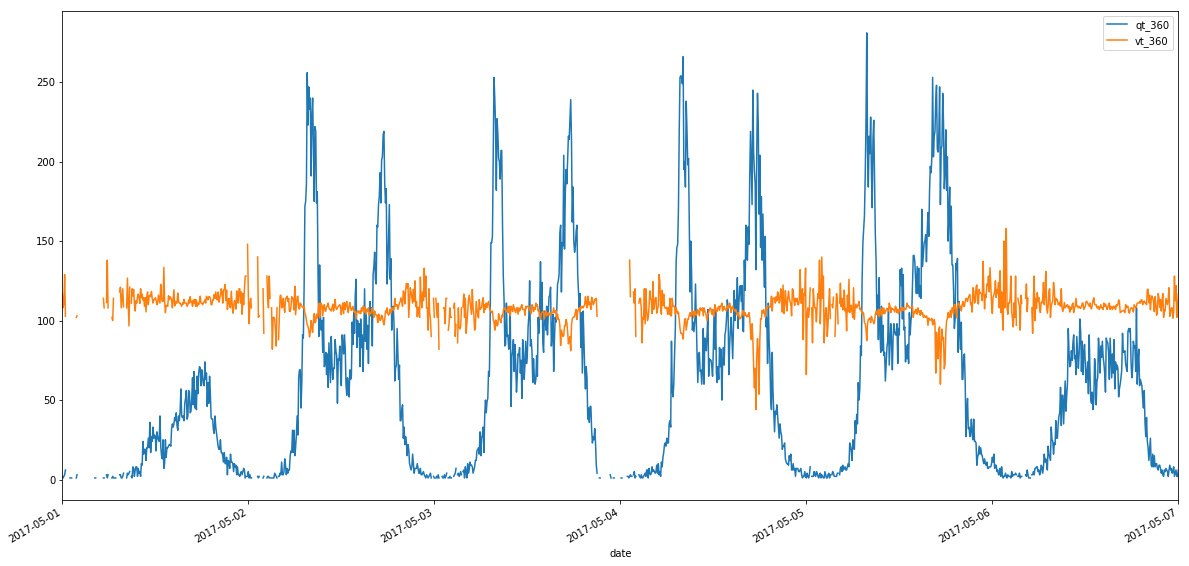

In [14]:
#DataFrameDict["MZE54.3"].plot()
DataGp[Missingkey].plot(figsize=(20,10))

In [15]:
#for simplifying df_1 is the alias of datagp in Missingkey=('2', 'SITE_03') which has a lot of missing values
df_1=DataGp[Missingkey]
#df_1[['vt_360','InterpolateLinear_vt']].plot(style=styles,figsize=(20,15));
df_1[ df_1.vt_360.isna()].sort_values(by='date').head()

,Macrosection,sens,code_centrale,code_canal,qt_360,vt_360
date,,,,,,
2017-05-01 00:30:00+02:00,I11,SENS_1,SITE_03,2,NaN,NaN
2017-05-01 00:42:00+02:00,I11,SENS_1,SITE_03,2,NaN,NaN
2017-05-01 00:54:00+02:00,I11,SENS_1,SITE_03,2,NaN,NaN
2017-05-01 01:06:00+02:00,I11,SENS_1,SITE_03,2,1.0,NaN
2017-05-01 01:18:00+02:00,I11,SENS_1,SITE_03,2,NaN,NaN


In [ ]:
#filling using mean and interpolation

# for speed

df_1 = df_1.assign(FillMean_vt=df_1.vt_360.fillna(df_1.vt_360.mean()))
df_1 = df_1.assign(FillMedian_vt=df_1.vt_360.fillna(df_1.vt_360.median()))


# for debit st
df_1 = df_1.assign(FillMean_qt=df_1.qt_360.fillna(df_1.qt_360.mean()))
df_1 = df_1.assign(FillMedian_qt=df_1.qt_360.fillna(df_1.qt_360.median()))

df_1.head()

#df_1.plot();


In [ ]:
%matplotlib inline
styles=['b-.', 'ko--', 'r.','go--', 'rx-']
df_1[['vt_360','FillMean_vt','FillMedian_vt']].plot(style = styles ,figsize=(20,15));


plotting

In [ ]:
%matplotlib inline
styles=['b--', 'go--', 'r*', 'y^-','g-']
df_1[['vt_360','InterpolateSpline3_vt']].plot(style = styles ,figsize=(20,17));

In [ ]:
%matplotlib inline
#styles=['b-.', 'ko', 'r.','go--', 'rx-']
df_1[['vt_360','InterpolateTime_vt']].plot(style = styles ,figsize=(20,15));

In [ ]:
%matplotlib inline
df_1[['vt_360','InterpolateCubic_vt']].plot(style=styles,figsize=(20,15));

In [ ]:
styles=['b-.', 'ko', 'r.','go--', 'rx-']#'k--', 'bo-', 'r*', 'y^-'
final_df.plot(style=styles, figsize=(20,10));
plt.ylabel('Temperature');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 14} );

In [ ]:

#filling using mean and interpolation

# for speed

df_1 = df_1.assign(FillMean_vt=df_1.vt_360.fillna(df_1.vt_360.mean()))
df_1 = df_1.assign(FillMedian_vt=df_1.vt_360.fillna(df_1.vt_360.median()))


# for debit st
df_1 = df_1.assign(FillMean_qt=df_1.qt_360.fillna(df_1.qt_360.mean()))
df_1 = df_1.assign(FillMedian_qt=df_1.qt_360.fillna(df_1.qt_360.median()))

df_1.head()

#df_1.plot();


# In[ ]:


get_ipython().run_line_magic('matplotlib', 'inline')
styles=['b-.', 'ko--', 'r.','go--', 'rx-']
df_1[['vt_360','FillMean_vt','FillMedian_vt']].plot(style = styles ,figsize=(20,15));


# plotting
# In one step debit

#df_1 = df_1.drop(["InterpolateSpline4", "InterpolateSpline5", "InterpolateSpline3"
#                  ,"InterpolatePoly7","InterpolatePoly5","InterpolateAkima"
#                  ,"InterpolateQuadratic","InterpolateCubic"], axis=1)


df_1 = df_1.assign(InterpolateLinear_qt=df_1.qt_360.interpolate(method='linear'))

df_1 = df_1.assign(InterpolateTime_qt=df_1.qt_360.interpolate(method='time'))

df_1 = df_1.assign(InterpolateSLinear_qt=df_1.qt_360.interpolate(method='slinear')) #spline 

df_1 = df_1.assign(InterpolateQuadratic_qt=df_1.qt_360.interpolate(method='quadratic'))

df_1 = df_1.assign(InterpolateCubic_qt=df_1.qt_360.interpolate(method='cubic'))

#df_1 = df_1.assign(InterpolateAkima_qt=df_1.qt_360.interpolate(method='akima')) the worst

df_1 = df_1.assign(InterpolatePoly5_qt=df_1.qt_360.interpolate(method='polynomial', order=5)) 

df_1 = df_1.assign(InterpolatePoly7_qt=df_1.qt_360.interpolate(method='polynomial', order=7))

df_1 = df_1.assign(InterpolateSpline3_qt=df_1.qt_360.interpolate(method='spline', order=3))

df_1 = df_1.assign(InterpolateSpline4_qt=df_1.qt_360.interpolate(method='spline', order=4))

df_1 = df_1.assign(InterpolateSpline5_qt=df_1.qt_360.interpolate(method='spline', order=5))


#speed
df_1 = df_1.assign(InterpolateLinear_vt=df_1.vt_360.interpolate(method='linear'))

df_1 = df_1.assign(InterpolateTime_vt=df_1.vt_360.interpolate(method='time'))

df_1 = df_1.assign(InterpolateSLinear_vt=df_1.vt_360.interpolate(method='slinear'))


df_1 = df_1.assign(InterpolateQuadratic_vt=df_1.vt_360.interpolate(method='quadratic'))

df_1 = df_1.assign(InterpolateCubic_vt=df_1.vt_360.interpolate(method='cubic'))

#df_1 = df_1.assign(InterpolateAkima_vt=df_1.vt_360.interpolate(method='akima')) the worst

df_1 = df_1.assign(InterpolatePoly5_vt=df_1.vt_360.interpolate(method='polynomial', order=5)) 

df_1 = df_1.assign(InterpolatePoly7_vt=df_1.vt_360.interpolate(method='polynomial', order=7))

df_1 = df_1.assign(InterpolateSpline3_vt=df_1.vt_360.interpolate(method='spline', order=3))

df_1 = df_1.assign(InterpolateSpline4_vt=df_1.vt_360.interpolate(method='spline', order=4))

df_1 = df_1.assign(InterpolateSpline5_vt=df_1.vt_360.interpolate(method='spline', order=5))


#df_1.columns
df_1[df_1.qt_360.isna()].head()
# In[ ]:


get_ipython().run_line_magic('matplotlib', 'inline')
styles=['b--', 'go--', 'r*', 'y^-','g-']
df_1[['vt_360','InterpolateSpline3_vt']].plot(style = styles ,figsize=(20,17));


# In[ ]:


get_ipython().run_line_magic('matplotlib', 'inline')
#styles=['b-.', 'ko', 'r.','go--', 'rx-']
df_1[['vt_360','InterpolateTime_vt']].plot(style = styles ,figsize=(20,15));


# In[ ]:


get_ipython().run_line_magic('matplotlib', 'inline')
df_1[['vt_360','InterpolateCubic_vt']].plot(style=styles,figsize=(20,15));

